# Projekat: Ball and Beam

## Potrebne biblioteke

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Okruženje

In [41]:
class Enviroment():
    # m - masa loptice (0.1113 kg je preporucena vrednost)
    # r - poluprecnik loptice (0.015 m je preporucena vrednost)
    # l - duzina grede (0.4 m je preporucena vrednost)
    # TIME_STEP - za diskretizaciju vremena (0.05 s je preporucena vrednost)
    # J - moment inercije za lopticu (J = 2/5 * m * r ^ 2)
    # alpha - ugao rotacije (ugao u radijanima)
    # g - gravitaciona konstanta (9.81 m/s^2 je preporucena vrednost)
    # kf - koeficijent trenja (0.5 je preporucena vrednost uz pretpostavku da je metalna loptica i drvena greda)
    # p - koeficijent kaznjavanja (1 je preporucena vrednost)
    def __init__(self, m: float = 0.113, r: float = 0.015, l: float = 0.4, g: float = 9.81, kf: float = 0.5, TIME_STEP: float = 0.05):
        self.m = m
        self.r = r
        self.l = l
        self.J = 0.4 * m * r ** 2
        self.g = g
        self.kf = kf
        self.TIME_STEP = TIME_STEP
        self.p = 1

        # Loptica se nalazi na sredini grede na pocetku i greda je u ravnoteznom polozaju
        # Ovo je u sustini stanje z = (z1, z2, z3, z4)
        self.x = 0
        self.x_dot = 0
        self.alpha = 0
        self.alpha_dot = 0

        # Ogranicenja maksimalnih vrednosti
        self.x_dot_max = 0.5
        self.alpha_max = 0.35
        self.alpha_dot_max = 1
        
        # Ako predjemo 500 koraka vraca se true za truncated (ogranicavamo duzinu epizode)
        self.steps = 0
        self.max_steps = 500
        self.trunc = False
        # Da li je loptica pala?
        self.term = False

        # Ugaono ubrzanje predstavlja akciju (rad/s^2)
        # Skup akcija
        self.actions = [-5, -2.5, 0, 2.5, 5]

    # Naredna funkcija je formula sa pdf-a
    def x_ddot(self):
        return - self.x_dot * (self.kf * self.r ** 2) / (self.m * self.r ** 2 + self.J) + np.sin(self.alpha) * (self.m * self.g * self.r ** 2) / (self.m * self.r ** 2 + self.J)

    # Funkcija nagrade dobijena primenom DRM bazirana na evaluacionim funkcijama
    def reward(self):
        reward = self.e_0() * self.e_1() * self.e_2()
        return reward
    
    # Evaluacione funkcije, date su u pdf-u
    def e_0(self):
        if self.x > self.l / 2 or self.x < - self.l / 2:
            return 0
        if self.x_dot > self.x_dot_max or self.x_dot < - self.x_dot_max:
            return 0
        if self.alpha > self.alpha_max or self.alpha < - self.alpha_max:
            return 0
        if self.alpha_dot > self.alpha_dot_max or self.alpha_dot < - self.alpha_dot_max:
            return 0
        return 1

    def e_1(self):
        return 1 - 2 * abs(self.x) / self.l

    def e_2(self):
        return 1 - self.p * abs(self.x_ddot()) 

    # alpha_ddot - akcija (ugaono ubrzanje) koje primenjujemo
    # action - akcija koju uzimamo
    # action predstavlja indeks unutar actions tako da indeksi [0,1,2,3,4] odgovaraju akcijama [-5, -2.5, 0, 2.5, 5]
    def take_action(self, action: int):
        self.steps += 1
        if self.steps > self.max_steps:
            self.trunc = True   # Znaci nije terminalno stanje (pad sipke), vec smo prosto dosli do kraja epizode
            self.term = False
            return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term

        # U slucaju da je loptica pala sa grede
        if self.x > self.l / 2 or self.x < - self.l / 2:
            self.term = True
            return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term
        
        # Primenom akcije menja se stanje
        alpha_ddot = self.actions[action]
        # Stanje je z = (z1, z2, z3, z4) pa je promena stanja definisana u naredne 4 linije
        self.x = self.x + self.TIME_STEP * self.x_dot
        self.x_dot = self.x_dot + self.TIME_STEP * self.x_ddot()
        self.alpha = self.alpha + self.TIME_STEP * self.alpha_dot
        self.alpha_dot = self.alpha_dot + self.TIME_STEP * alpha_ddot

        return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term

    #Reset okruzenja kako bi se mogla odigrati nova epizoda, resetuje se stanje, kako se epizoda zavrsila i korak u epizodi 
    def reset(self):
        self.x = 0
        self.x_dot = 0
        self.alpha = 0
        self.alpha_dot = 0
        self.steps = 0
        self.trunc = False
        self.term = False
        return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term

In [42]:
env = Enviroment(m = 0.113, r = 0.015, l = 0.4, g = 9.81, kf = 0.5, TIME_STEP = 0.05)

## Diskretizacija

In [43]:
# Broj binova za svaku dimenziju stanja
N_X_BINS = 20
N_X_DOT_BINS = 20
N_ALPHA_BINS = 20
N_ALPHA_DOT_BINS = 20

# Granice za diskretizaciju
# Stavljao sam isto ogranicenje kao da su thresholdi, koji su definisani u e0 u pdf fajlu :)

# Ove promenljive su dodate kako bi se lakse menjale njihove vrednosti ako treba :)
x_th = 0.2
x_dot_th = 0.5
alpha_th = 0.35
alpha_dot_th = 1

# Granice za poziciju
x_bins = np.linspace(-x_th, x_th, N_X_BINS + 1)
# Granice brzina - namesteno da se sistem ponasa "realno"
x_dot_bins = np.linspace(-x_dot_th, x_dot_th, N_X_DOT_BINS + 1)
# Granice za ugao u radijanima
alpha_bins = np.linspace(-alpha_th, alpha_th, N_ALPHA_BINS + 1)  
# Granice za ugaonu brzinu moraju biti male kako bi sistem bio stabilan
alpha_dot_bins = np.linspace(-alpha_dot_th, alpha_dot_th, N_ALPHA_DOT_BINS + 1)

# Funkcija za konverziju kontinualnog stanja u diskretni indeks
def discretize_state(state):
    x, x_dot, alpha, alpha_dot = state
    
    # clip sprecava pojavu ekstremnih vrednosti tako sto neki autsajder postave na njemu najblizu granicu
    x = np.clip(x, -x_th, x_th)
    x_dot = np.clip(x_dot, -x_dot_th, x_dot_th)
    alpha = np.clip(alpha, -alpha_th, alpha_th)
    alpha_dot = np.clip(alpha_dot, -alpha_dot_th, alpha_dot_th)
    
    # digitize - vraca vrednost bina u koji spada vrednost
    x_idx = np.digitize(x, x_bins) - 1
    x_dot_idx = np.digitize(x_dot, x_dot_bins) - 1
    theta_idx = np.digitize(alpha, alpha_bins) - 1
    theta_dot_idx = np.digitize(alpha_dot, alpha_dot_bins) - 1
    
    # clamp - osigurava da indeks nikad ne izadje van validnog opsega
    x_idx = max(0, min(x_idx, N_X_BINS - 1))
    x_dot_idx = max(0, min(x_dot_idx, N_X_DOT_BINS - 1))
    alpha_idx = max(0, min(theta_idx, N_ALPHA_BINS - 1))
    alpha_dot_idx = max(0, min(theta_dot_idx, N_ALPHA_DOT_BINS - 1))
    
    return (x_idx, x_dot_idx, alpha_idx, alpha_dot_idx)

## Treniranje agenata

### Vizualizacija treniranja

In [44]:
# Vizuelizacija q learning a

def visualize_q_learning():

    plt.figure(figsize=(15, 10))

    # 1. Raw rewards
    plt.subplot(2, 3, 1)
    plt.plot(rewards_per_episode, alpha=0.3, color='blue')
    plt.xlabel('Epizoda')
    plt.ylabel('Ukupna nagrada')
    plt.title('Nagrade tokom treniranja (raw)')

    # 2. Raw steps
    plt.subplot(2, 3, 2)
    plt.plot(steps_per_episode, alpha=0.3, color='green')
    plt.xlabel('Epizoda')
    plt.ylabel('Broj koraka')
    plt.title('Broj koraka po epizodi (raw)')

    # 3. Epsilon decay
    plt.subplot(2, 3, 3)
    epsilons = [1 - i * 0.0001 if 1 - i * 0.0001 > 0.01 else 0.01 for i in range(EPISODES)]
    plt.plot(epsilons, color='red')
    plt.xlabel('Epizoda')
    plt.ylabel('Epsilon')
    plt.title('Epsilon decay tokom treniranja')

    # 4. Moving average nagrade - prikazuje konvergenciju
    plt.subplot(2, 3, 4)
    window = 100
    moving_avg_rewards = np.convolve(
        rewards_per_episode,
        np.ones(window)/window,
        mode='valid'
    )
    plt.plot(moving_avg_rewards, color='blue', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečna nagrada')
    plt.title(f'Pokretni prosek nagrade ({window} epizoda)')

    # 5. Moving average koraka - prikazuje konvergenciju
    plt.subplot(2, 3, 5)
    moving_avg_steps = np.convolve(
        steps_per_episode,
        np.ones(window)/window,
        mode='valid'
    )
    plt.plot(moving_avg_steps, color='green', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečan broj koraka')
    plt.title(f'Pokretni prosek koraka ({window} epizoda)')

    # 6. Poslednje epizode (zoom)
    plt.subplot(2, 3, 6)
    last_n = 1000
    plt.plot(rewards_per_episode[-last_n:], alpha=0.5)
    plt.xlabel('Epizoda')
    plt.ylabel('Nagrada')
    plt.title(f'Poslednjih {last_n} epizoda (detalj)')

    plt.tight_layout()
    plt.show()


# Vizuelizacija sarse

def visualize_sarsa():
    plt.figure(figsize=(15, 10))

    # 1. Raw rewards
    plt.subplot(2, 3, 1)
    plt.plot(rewards_per_episode_S, alpha=0.3, color='orange')
    plt.xlabel('Epizoda')
    plt.ylabel('Ukupna nagrada')
    plt.title('Nagrade tokom treniranja (raw)')

    # 2. Raw steps
    plt.subplot(2, 3, 2)
    plt.plot(steps_per_episode_S, alpha=0.3, color='purple')
    plt.xlabel('Epizoda')
    plt.ylabel('Broj koraka')
    plt.title('Broj koraka po epizodi (raw)')

    # 3. Epsilon decay
    plt.subplot(2, 3, 3)
    epsilons_S = [max(EPS_MIN_S, 1 - i * eps_decay_rate_S) for i in range(EPISODES_S)]
    plt.plot(epsilons_S, color='red')
    plt.xlabel('Epizoda')
    plt.ylabel('Epsilon')
    plt.title('Epsilon decay tokom treniranja')

    # 4. Moving average nagrade
    plt.subplot(2, 3, 4)
    window = 100
    moving_avg_rewards_S = np.convolve(
        rewards_per_episode_S,
        np.ones(window) / window,
        mode='valid'
    )
    plt.plot(moving_avg_rewards_S, color='orange', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečna nagrada')
    plt.title(f'Pokretni prosek nagrade ({window} epizoda)')

    # 5. Moving average koraka
    plt.subplot(2, 3, 5)
    moving_avg_steps_S = np.convolve(
        steps_per_episode_S,
        np.ones(window) / window,
        mode='valid'
    )
    plt.plot(moving_avg_steps_S, color='purple', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečan broj koraka')
    plt.title(f'Pokretni prosek koraka ({window} epizoda)')

    # 6. Poslednje epizode (zoom)
    plt.subplot(2, 3, 6)
    last_n = 1000
    plt.plot(rewards_per_episode_S[-last_n:], alpha=0.5, color='orange')
    plt.xlabel('Epizoda')
    plt.ylabel('Nagrada')
    plt.title(f'Poslednjih {last_n} epizoda (detalj)')

    plt.tight_layout()
    plt.show()


# Uporedna vizualizacija Q-Learning vs SARSA
def visualize_comparison():
    window = 100
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Q-Learning vs SARSA — poređenje', fontsize=14, fontweight='bold')

    def moving_avg(data):
        return np.convolve(data, np.ones(window) / window, mode='valid')

    # Nagrade
    ax = axes[0]
    ax.plot(moving_avg(rewards_per_episode), color='blue', linewidth=2, label='Q-Learning')
    ax.plot(moving_avg(rewards_per_episode_S), color='orange', linewidth=2, label='SARSA')
    ax.set_xlabel('Epizoda')
    ax.set_ylabel('Prosečna nagrada')
    ax.set_title(f'Pokretni prosek nagrade ({window} epizoda)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Koraci
    ax = axes[1]
    ax.plot(moving_avg(steps_per_episode), color='green', linewidth=2, label='Q-Learning')
    ax.plot(moving_avg(steps_per_episode_S), color='purple', linewidth=2, label='SARSA')
    ax.set_xlabel('Epizoda')
    ax.set_ylabel('Prosečan broj koraka')
    ax.set_title(f'Pokretni prosek koraka ({window} epizoda)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Q-Learning agent

In [45]:
# Politika koju koristimo u q learning
def eps_greedy(q, eps: float):
    if random.random() > eps:
        return np.argmax(q)
    else:                                   
        return random.randint(0, 4)          # 0-4 jer imam 5 akcija i zelim da svaka moze biti odabrana

In [46]:
# Agent
ALPHA_Q = 0.1      # learning rate - koliko brzo agent uci iz novih iskustava

GAMMA_Q = 0.99     # discount factor - govori koliko agent ceni buduce nagrade
                    
Q = np.zeros((N_X_BINS, N_X_DOT_BINS, N_ALPHA_BINS, N_ALPHA_DOT_BINS, 5))   # 5 jer imamo 5 akcija [-5, -2.5, 0, 2.5, 5]

#epsilon sa decay stopom jer zelimo prvo eksloraciju a potom eksploataciju
EPSILON = 1
eps_decay_rate = 0.0001 
EPISODES = 15000

#za pracenje napretka
rewards_per_episode = []
steps_per_episode = []

#trening petlja
for episode in range(EPISODES):
    EPSILON -= eps_decay_rate if EPSILON > 0.001 else 0

    #resetujem okruzenje
    state, _, _, _ = env.reset()
    state_idx = discretize_state(state)
    total_reward = 0
    done = False

    #epizoda
    while not done:
        action = eps_greedy(Q[state_idx], EPSILON)
        next_state, reward, truncated, terminated = env.take_action(action)
        next_state_idx = discretize_state(next_state)

        #q-learning update formula
        # Q(s,a) = Q(s,a) + α * [r + γ * max(Q(s',a')) - Q(s,a)] 
        Q[state_idx][action] += ALPHA_Q*(reward + GAMMA_Q*np.max(Q[next_state_idx]) - Q[state_idx][action] ) 

        #predji na sledece stanje
        state_idx = next_state_idx
        total_reward += reward

        #provera da li je epizoda zavrsena
        done = terminated or truncated
        
    #cuvam rezultate epizode
    rewards_per_episode.append(total_reward)
    steps_per_episode.append(env.steps)

    #na svakih 1000 epizoda zelim da ispisem napredak
    if(episode + 1) % 1000 == 0:
        avg_reward = np.mean(rewards_per_episode[-1000 :])
        avg_steps = np.mean(steps_per_episode[-1000 :])
        print(f"Epizoda {episode+1}/{EPISODES}, Prosecna nagrada>> {avg_reward:.2f}, Prosecan broj koraka>> {avg_steps:.2f}, Epsilon>>{EPSILON:.2f}")


Epizoda 1000/15000, Prosecna nagrada>> 11.88, Prosecan broj koraka>> 29.13, Epsilon>>0.90
Epizoda 2000/15000, Prosecna nagrada>> 13.89, Prosecan broj koraka>> 31.48, Epsilon>>0.80
Epizoda 3000/15000, Prosecna nagrada>> 16.71, Prosecan broj koraka>> 35.20, Epsilon>>0.70
Epizoda 4000/15000, Prosecna nagrada>> 20.00, Prosecan broj koraka>> 39.03, Epsilon>>0.60
Epizoda 5000/15000, Prosecna nagrada>> 24.22, Prosecan broj koraka>> 44.67, Epsilon>>0.50
Epizoda 6000/15000, Prosecna nagrada>> 29.83, Prosecan broj koraka>> 51.62, Epsilon>>0.40
Epizoda 7000/15000, Prosecna nagrada>> 39.71, Prosecan broj koraka>> 63.74, Epsilon>>0.30
Epizoda 8000/15000, Prosecna nagrada>> 64.28, Prosecan broj koraka>> 93.23, Epsilon>>0.20
Epizoda 9000/15000, Prosecna nagrada>> 156.06, Prosecan broj koraka>> 198.34, Epsilon>>0.10
Epizoda 10000/15000, Prosecna nagrada>> 376.56, Prosecan broj koraka>> 421.59, Epsilon>>0.00
Epizoda 11000/15000, Prosecna nagrada>> 472.74, Prosecan broj koraka>> 501.00, Epsilon>>0.00
Ep

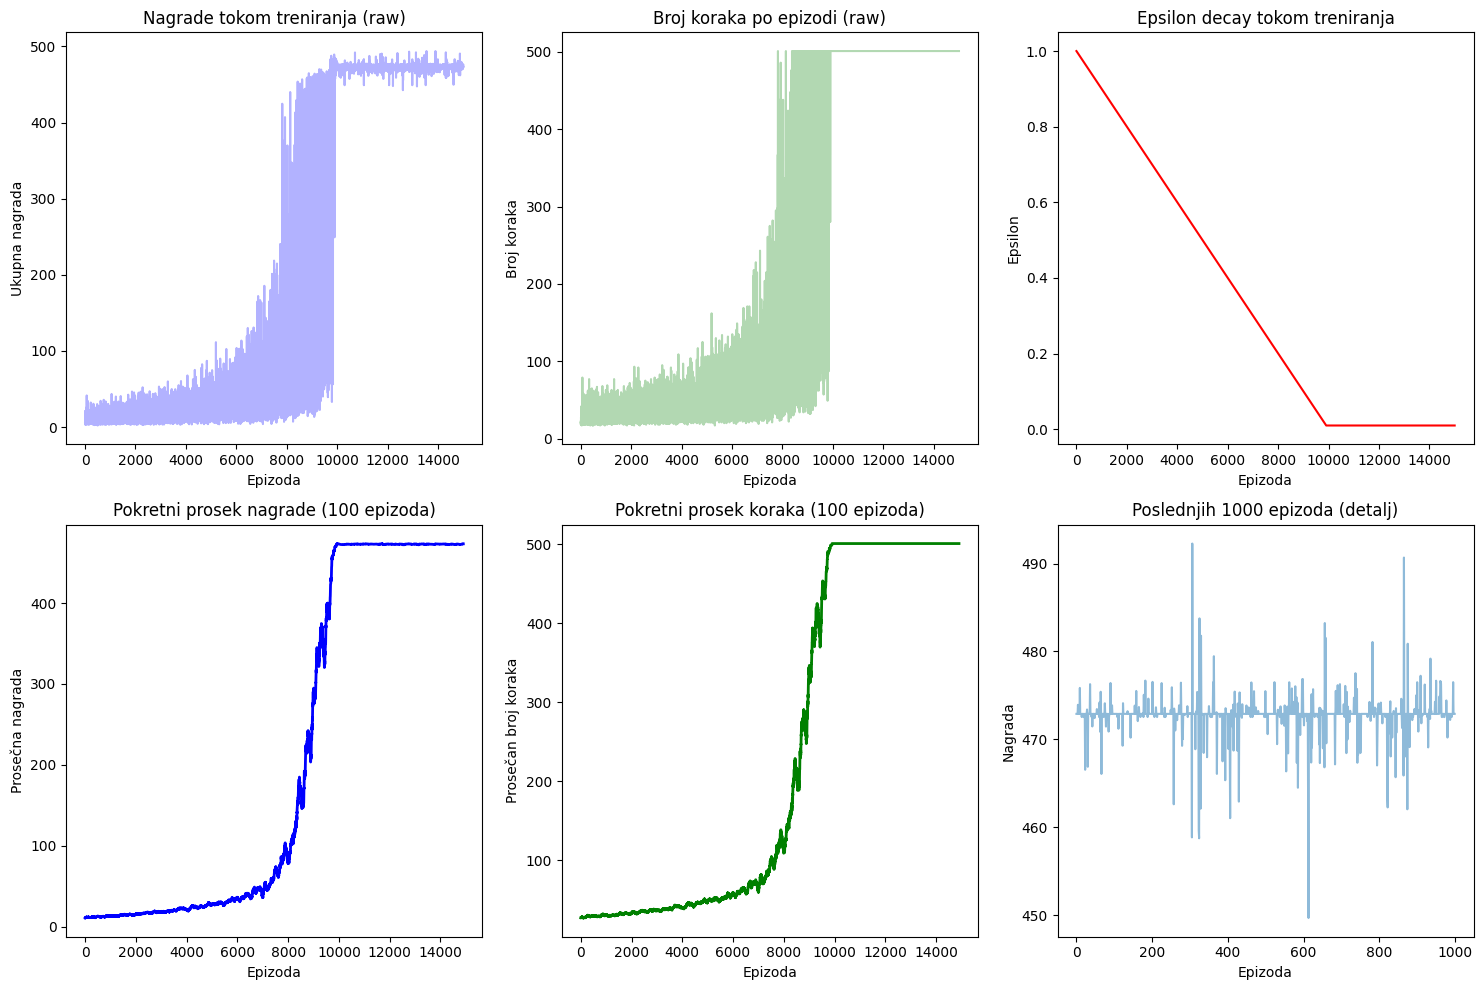

In [47]:
visualize_q_learning()

### SARSA agent

In [48]:
# Agent
ALPHA_S = 0.1
GAMMA_S = 0.99

Q_S = np.zeros((N_X_BINS, N_X_DOT_BINS, N_ALPHA_BINS, N_ALPHA_DOT_BINS, 5))

EPSILON_S = 1
eps_decay_rate_S = 0.0001
EPS_MIN_S = 0.01
EPISODES_S = 15000

rewards_per_episode_S = []
steps_per_episode_S = []

for episode in range(EPISODES_S):
    EPSILON_S = max(EPS_MIN_S, EPSILON_S - eps_decay_rate_S)

    state, _, _, _ = env.reset()
    state_idx = discretize_state(state)
    
    # SARSA: akcija se bira NA POCETKU epizode, pre petlje
    action = eps_greedy(Q_S[state_idx], EPSILON_S)
    
    total_reward = 0
    done = False

    while not done:
        next_state, reward, truncated, terminated = env.take_action(action)
        next_state_idx = discretize_state(next_state)

        # SARSA: sledeca akcija se bira epsilon-greedy (ne max!)
        next_action = eps_greedy(Q_S[next_state_idx], EPSILON_S)

        # SARSA update formula:
        # Q(s,a) = Q(s,a) + α * [r + γ * Q(s', a') - Q(s,a)]
        # Razlika vs Q-Learning: koristimo Q(s', a') gde je a' vec odabrana,
        # a ne max_a'(Q(s', a')) — zato je SARSA on-policy
        Q_S[state_idx][action] += ALPHA_S * ( reward + GAMMA_S * Q_S[next_state_idx][next_action] - Q_S[state_idx][action])

        # Prenosimo odabranu akciju u sledeci korak (kljucna razlika u odnosu na Q-Learning)
        state_idx = next_state_idx
        action = next_action
        total_reward += reward

        done = terminated or truncated

    rewards_per_episode_S.append(total_reward)
    steps_per_episode_S.append(env.steps)

    if (episode + 1) % 1000 == 0:
        avg_reward = np.mean(rewards_per_episode_S[-1000:])
        avg_steps = np.mean(steps_per_episode_S[-1000:])
        print(f"Epizoda {episode+1}/{EPISODES_S}, Prosecna nagrada>> {avg_reward:.2f}, Prosecan broj koraka>> {avg_steps:.2f}, Epsilon>> {EPSILON_S:.4f}")

Epizoda 1000/15000, Prosecna nagrada>> 11.93, Prosecan broj koraka>> 29.11, Epsilon>> 0.9000
Epizoda 2000/15000, Prosecna nagrada>> 14.10, Prosecan broj koraka>> 31.83, Epsilon>> 0.8000
Epizoda 3000/15000, Prosecna nagrada>> 16.38, Prosecan broj koraka>> 34.54, Epsilon>> 0.7000
Epizoda 4000/15000, Prosecna nagrada>> 19.07, Prosecan broj koraka>> 38.10, Epsilon>> 0.6000
Epizoda 5000/15000, Prosecna nagrada>> 23.57, Prosecan broj koraka>> 43.66, Epsilon>> 0.5000
Epizoda 6000/15000, Prosecna nagrada>> 28.67, Prosecan broj koraka>> 50.10, Epsilon>> 0.4000
Epizoda 7000/15000, Prosecna nagrada>> 35.26, Prosecan broj koraka>> 57.62, Epsilon>> 0.3000
Epizoda 8000/15000, Prosecna nagrada>> 42.04, Prosecan broj koraka>> 64.93, Epsilon>> 0.2000
Epizoda 9000/15000, Prosecna nagrada>> 58.04, Prosecan broj koraka>> 82.61, Epsilon>> 0.1000
Epizoda 10000/15000, Prosecna nagrada>> 188.83, Prosecan broj koraka>> 219.84, Epsilon>> 0.0100
Epizoda 11000/15000, Prosecna nagrada>> 308.62, Prosecan broj korak

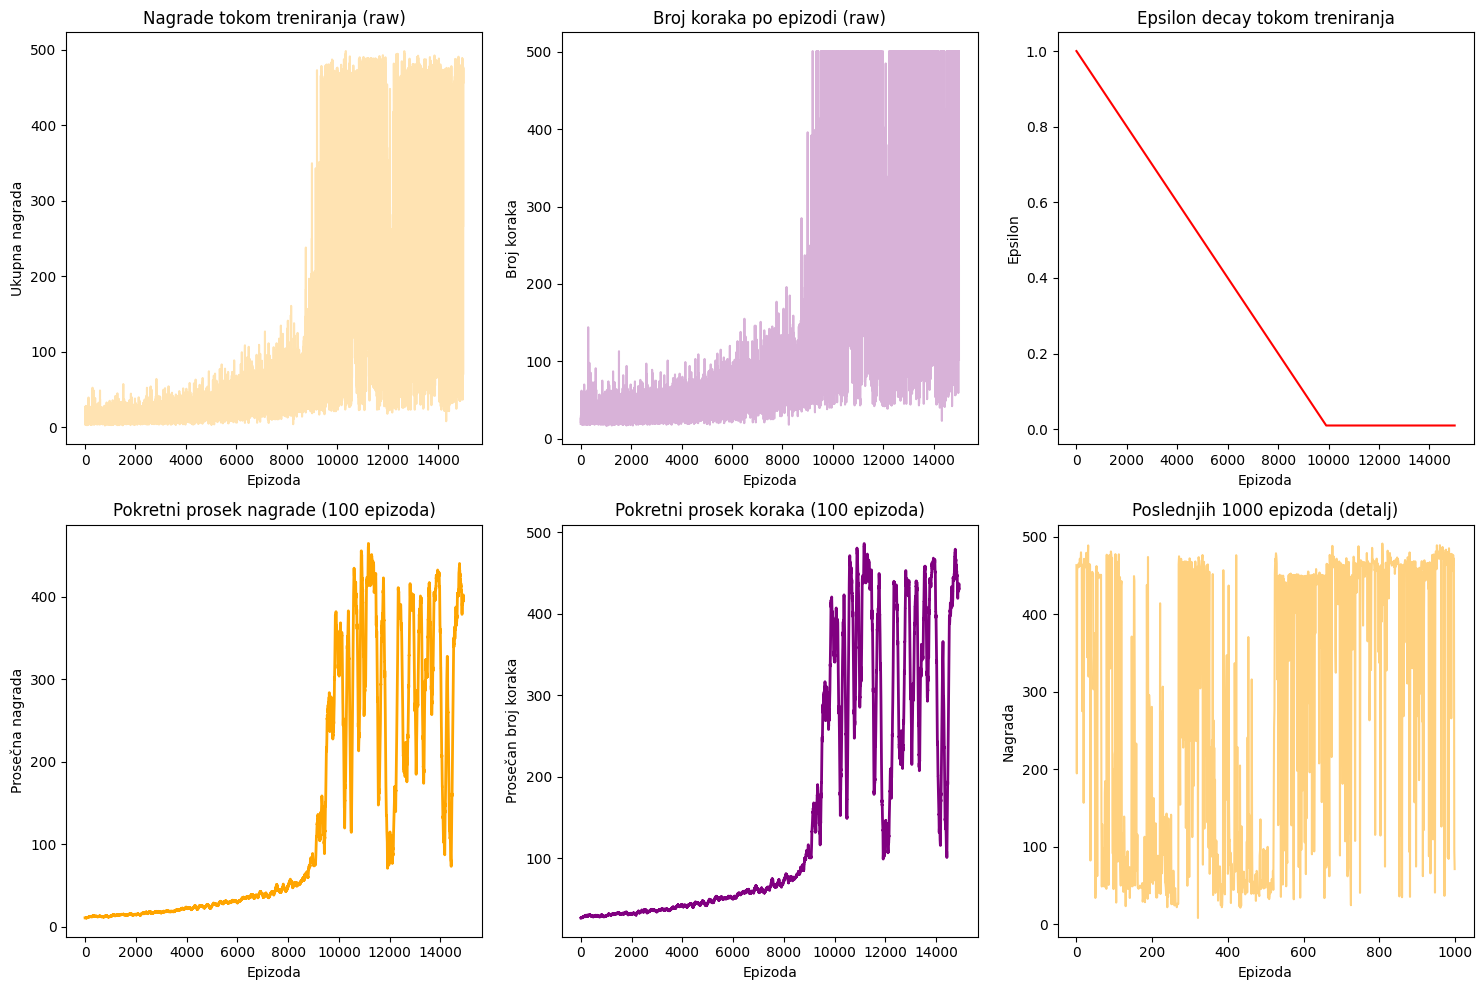

In [49]:
visualize_sarsa()

## Zaključak

Uporedni pregled Q-learning vs SARSA

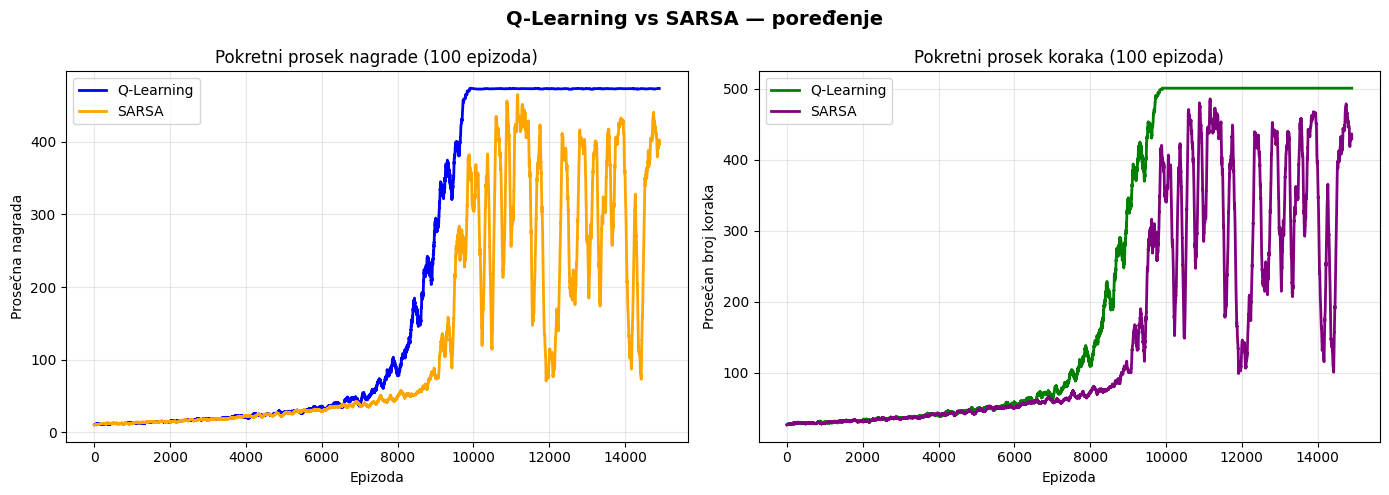

In [51]:
visualize_comparison()